In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


Using device: cuda


In [2]:
# Load preprocessed data
CSV_PATH = r"data/train(1)(train(1)).csv"
IMAGE_DIR = r"property_images_v2"

df = pd.read_csv(CSV_PATH)
print(f"Dataset loaded: {len(df)} rows")

# Verify image paths
def verify_image_path(prop_id):
    path = os.path.join(IMAGE_DIR, f"{prop_id}.png")
    return path if os.path.exists(path) else None

df['image_path'] = df['id'].apply(verify_image_path)
df = df.dropna(subset=['image_path']).copy()

# Handle outliers
price_limit = df['price'].quantile(0.99)
df = df[df['price'] < price_limit].copy()

print(f"After cleaning: {len(df)} rows")


Dataset loaded: 16209 rows
After cleaning: 16046 rows


In [3]:
# Feature engineering (same as preprocessing notebook)
# Log transform target
df['log_price'] = np.log1p(df['price'])

# Log transform skewed features
for col in ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']:
    if col in df.columns:
        df[col] = np.log1p(df[col]).astype('float64')

# Split BEFORE engineering to avoid leakage
train_raw, test_raw = train_test_split(df, test_size=0.2, random_state=42)

# Calculate Luxury Hub ONLY from Training data
lux_threshold = train_raw['price'].quantile(0.95)
hub_lat = train_raw[train_raw['price'] >= lux_threshold]['lat'].mean()
hub_long = train_raw[train_raw['price'] >= lux_threshold]['long'].mean()

def finalize_features(data):
    d = data.copy()
    d['dist_to_hub'] = np.sqrt((d['lat'] - hub_lat)**2 + (d['long'] - hub_long)**2)
    d['house_age'] = (2015 - d['yr_built']).astype('float64')
    return d

train_raw = finalize_features(train_raw)
test_raw = finalize_features(test_raw)

print(f"Training samples: {len(train_raw)}")
print(f"Test samples: {len(test_raw)}")


Training samples: 12836
Test samples: 3210


In [4]:
# CNN Feature Extractor (same as main notebook)
class VisualFeatureExtractor(nn.Module):
    def __init__(self):
        super(VisualFeatureExtractor, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

cnn_net = VisualFeatureExtractor().to(device)
cnn_net.eval()

img_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("CNN Feature Extractor initialized")


CNN Feature Extractor initialized


In [5]:
# Extract visual scores for all data
def get_visual_scores(ids, image_folder):
    scores = []
    with torch.no_grad():
        for img_id in tqdm(ids, desc="Extracting Visual Features"):
            path = os.path.join(image_folder, f"{img_id}.png")
            if os.path.exists(path):
                try:
                    img = Image.open(path).convert('RGB')
                    img_t = img_transform(img).unsqueeze(0).to(device)
                    score = cnn_net(img_t).cpu().numpy().mean()
                    scores.append(score)
                except:
                    scores.append(0.5)
            else:
                scores.append(0.5)
    return np.array(scores, dtype='float64')

print("Extracting visual features for training data...")
train_raw['visual_score'] = get_visual_scores(train_raw['id'], IMAGE_DIR)

print("Extracting visual features for test data...")
test_raw['visual_score'] = get_visual_scores(test_raw['id'], IMAGE_DIR)

print("Visual feature extraction complete!")


Extracting visual features for training data...


Extracting Visual Features: 100%|██████████| 12836/12836 [05:33<00:00, 38.48it/s] 


Extracting visual features for test data...


Extracting Visual Features: 100%|██████████| 3210/3210 [00:23<00:00, 136.13it/s]

Visual feature extraction complete!


In [6]:
# Prepare tabular-only features (NO visual_score)
tabular_features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 
    'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 
    'sqft_living15', 'dist_to_hub', 'house_age'
]

X_train_tabular = train_raw[tabular_features].astype('float64')
X_test_tabular = test_raw[tabular_features].astype('float64')
y_train = train_raw['log_price'].values
y_test = test_raw['log_price'].values

print(f"Tabular features shape: {X_train_tabular.shape}")
print(f"Features: {tabular_features}")


Tabular features shape: (12836, 14)
Features: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'dist_to_hub', 'house_age']


In [7]:
# Train Tabular-Only Model (same ensemble as main notebook)
print("Training Tabular-Only Model...")
tabular_model = VotingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=500, max_depth=15, n_jobs=-1, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=8, 
                             tree_method='hist', random_state=42)),
        ('cat', CatBoostRegressor(iterations=1200, learning_rate=0.03, depth=8, 
                                 verbose=0, random_state=42))
    ],
    weights=[0.2, 0.4, 0.4]
)

tabular_model.fit(X_train_tabular, y_train)

# Predictions
preds_tabular_log = tabular_model.predict(X_test_tabular)
preds_tabular_usd = np.expm1(preds_tabular_log)
actual_usd = np.expm1(y_test)

# Metrics
r2_tabular = r2_score(y_test, preds_tabular_log)
mae_tabular = mean_absolute_error(actual_usd, preds_tabular_usd)
rmse_tabular = np.sqrt(mean_squared_error(actual_usd, preds_tabular_usd))

print("\n" + "="*50)
print("TABULAR-ONLY MODEL RESULTS")
print("="*50)
print(f"R² Score: {r2_tabular:.4f}")
print(f"MAE: ${mae_tabular:,.2f}")
print(f"RMSE: ${rmse_tabular:,.2f}")
print("="*50)


Training Tabular-Only Model...

TABULAR-ONLY MODEL RESULTS
R² Score: 0.8925
MAE: $59,512.36
RMSE: $98,052.68


## 4. Model 2: Multimodal (Tabular + Images)


In [8]:
# Prepare multimodal features (INCLUDES visual_score)
multimodal_features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 
    'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 
    'sqft_living15', 'visual_score', 'dist_to_hub', 'house_age'
]

X_train_multimodal = train_raw[multimodal_features].astype('float64')
X_test_multimodal = test_raw[multimodal_features].astype('float64')

print(f"Multimodal features shape: {X_train_multimodal.shape}")
print(f"Features: {multimodal_features}")


Multimodal features shape: (12836, 15)
Features: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'visual_score', 'dist_to_hub', 'house_age']


In [9]:
# Train Multimodal Model (same ensemble architecture)
print("Training Multimodal Model (Tabular + Images)...")
multimodal_model = VotingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=500, max_depth=15, n_jobs=-1, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=8, 
                             tree_method='hist', random_state=42)),
        ('cat', CatBoostRegressor(iterations=1200, learning_rate=0.03, depth=8, 
                                 verbose=0, random_state=42))
    ],
    weights=[0.2, 0.4, 0.4]
)

multimodal_model.fit(X_train_multimodal, y_train)

# Predictions
preds_multimodal_log = multimodal_model.predict(X_test_multimodal)
preds_multimodal_usd = np.expm1(preds_multimodal_log)

# Metrics
r2_multimodal = r2_score(y_test, preds_multimodal_log)
mae_multimodal = mean_absolute_error(actual_usd, preds_multimodal_usd)
rmse_multimodal = np.sqrt(mean_squared_error(actual_usd, preds_multimodal_usd))

print("\n" + "="*50)
print("MULTIMODAL MODEL RESULTS (Tabular + Images)")
print("="*50)
print(f"R² Score: {r2_multimodal:.4f}")
print(f"MAE: ${mae_multimodal:,.2f}")
print(f"RMSE: ${rmse_multimodal:,.2f}")
print("="*50)


Training Multimodal Model (Tabular + Images)...

MULTIMODAL MODEL RESULTS (Tabular + Images)
R² Score: 0.8919
MAE: $59,692.29
RMSE: $98,246.95


## 5. Model Comparison and Visualization


In [10]:
# Create comparison summary
comparison_results = pd.DataFrame({
    'Model': ['Tabular Only', 'Multimodal (Tabular + Images)'],
    'R² Score': [r2_tabular, r2_multimodal],
    'MAE ($)': [mae_tabular, mae_multimodal],
    'RMSE ($)': [rmse_tabular, rmse_multimodal]
})

print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_results.to_string(index=False))
print("="*60)

# Calculate improvement
r2_improvement = ((r2_multimodal - r2_tabular) / r2_tabular) * 100
mae_improvement = ((mae_tabular - mae_multimodal) / mae_tabular) * 100
rmse_improvement = ((rmse_tabular - rmse_multimodal) / rmse_tabular) * 100

print(f"\nImprovement with Multimodal Approach:")
print(f"  R² Score: {r2_improvement:+.2f}%")
print(f"  MAE: {mae_improvement:+.2f}% (lower is better)")
print(f"  RMSE: {rmse_improvement:+.2f}% (lower is better)")
print("="*60)


MODEL COMPARISON SUMMARY
                        Model  R² Score      MAE ($)     RMSE ($)
                 Tabular Only  0.892474 59512.364043 98052.677277
Multimodal (Tabular + Images)  0.891880 59692.286013 98246.951134

Improvement with Multimodal Approach:
  R² Score: -0.07%
  MAE: -0.30% (lower is better)
  RMSE: -0.20% (lower is better)


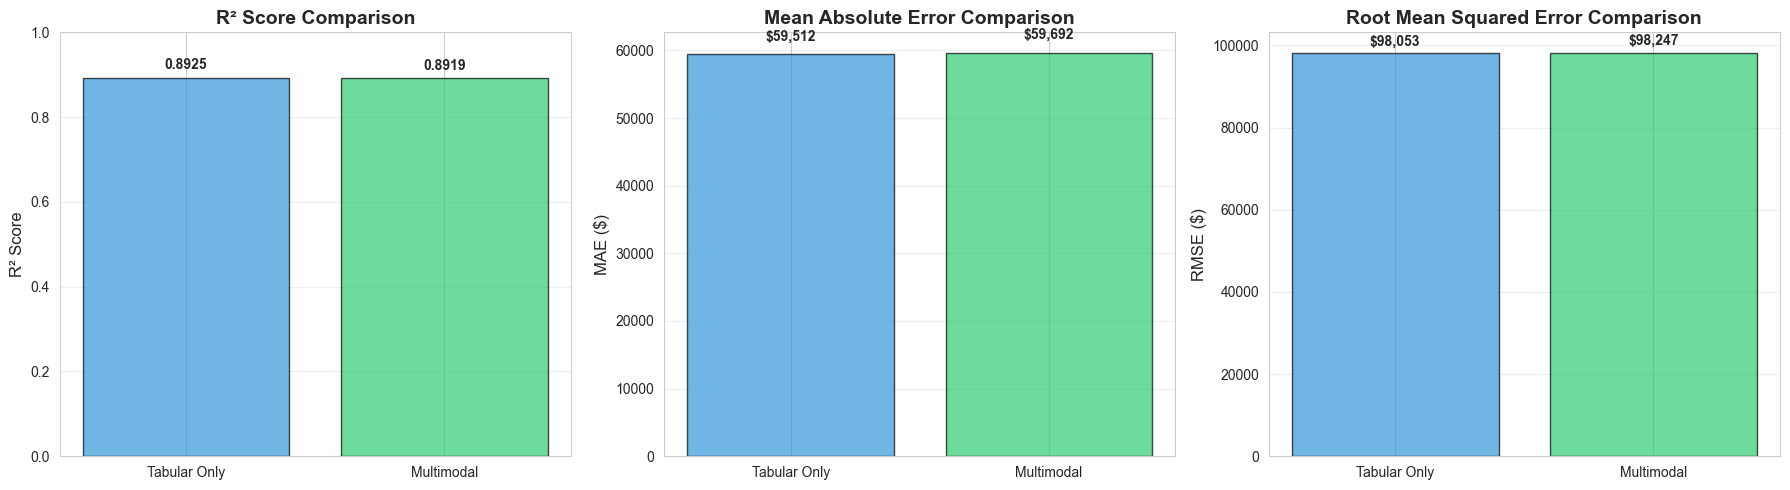

In [11]:
# Visualize metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Tabular Only', 'Multimodal']
colors = ['#3498db', '#2ecc71']

# R² Score
axes[0].bar(models, [r2_tabular, r2_multimodal], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([r2_tabular, r2_multimodal]):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# MAE
axes[1].bar(models, [mae_tabular, mae_multimodal], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('MAE ($)', fontsize=12)
axes[1].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([mae_tabular, mae_multimodal]):
    axes[1].text(i, v + 2000, f'${v:,.0f}', ha='center', fontweight='bold')

# RMSE
axes[2].bar(models, [rmse_tabular, rmse_multimodal], color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('RMSE ($)', fontsize=12)
axes[2].set_title('Root Mean Squared Error Comparison', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate([rmse_tabular, rmse_multimodal]):
    axes[2].text(i, v + 2000, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


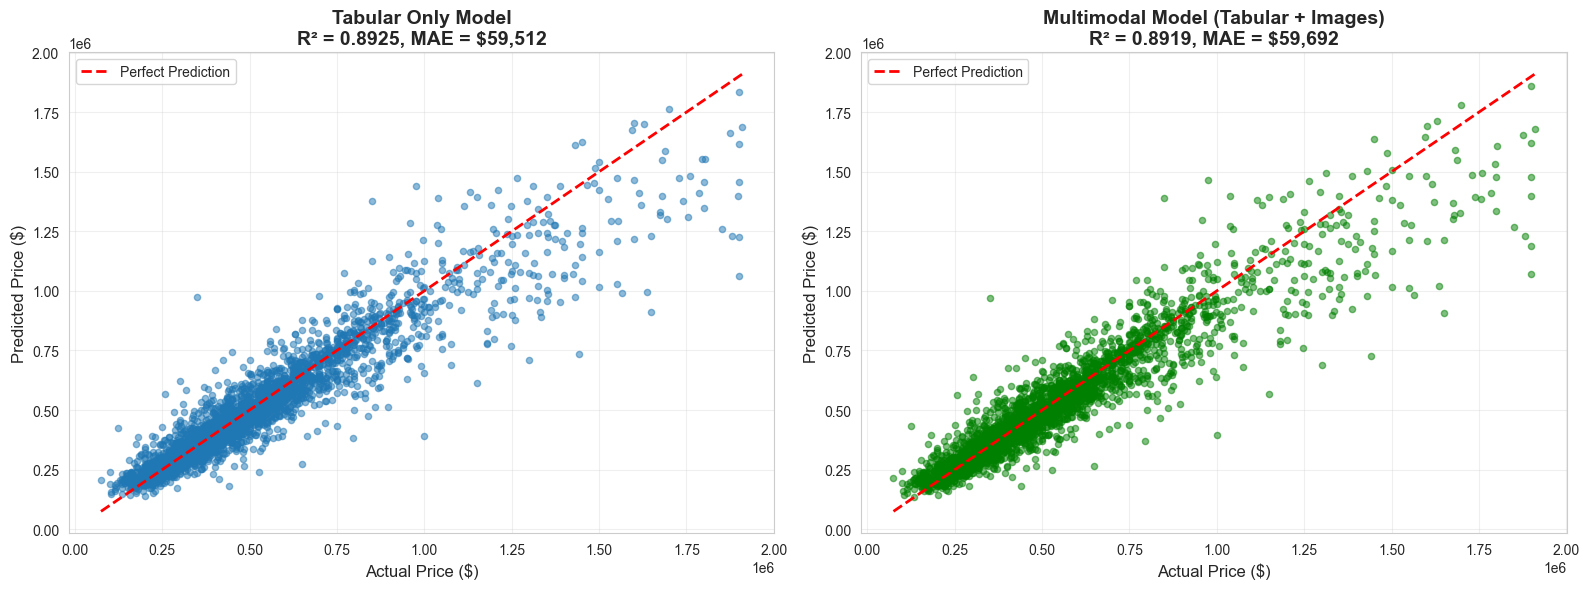

In [12]:
# Prediction scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Tabular Only
axes[0].scatter(actual_usd, preds_tabular_usd, alpha=0.5, s=20)
axes[0].plot([actual_usd.min(), actual_usd.max()], 
             [actual_usd.min(), actual_usd.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title(f'Tabular Only Model\nR² = {r2_tabular:.4f}, MAE = ${mae_tabular:,.0f}', 
                 fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Multimodal
axes[1].scatter(actual_usd, preds_multimodal_usd, alpha=0.5, s=20, color='green')
axes[1].plot([actual_usd.min(), actual_usd.max()], 
             [actual_usd.min(), actual_usd.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Predicted Price ($)', fontsize=12)
axes[1].set_title(f'Multimodal Model (Tabular + Images)\nR² = {r2_multimodal:.4f}, MAE = ${mae_multimodal:,.0f}', 
                 fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


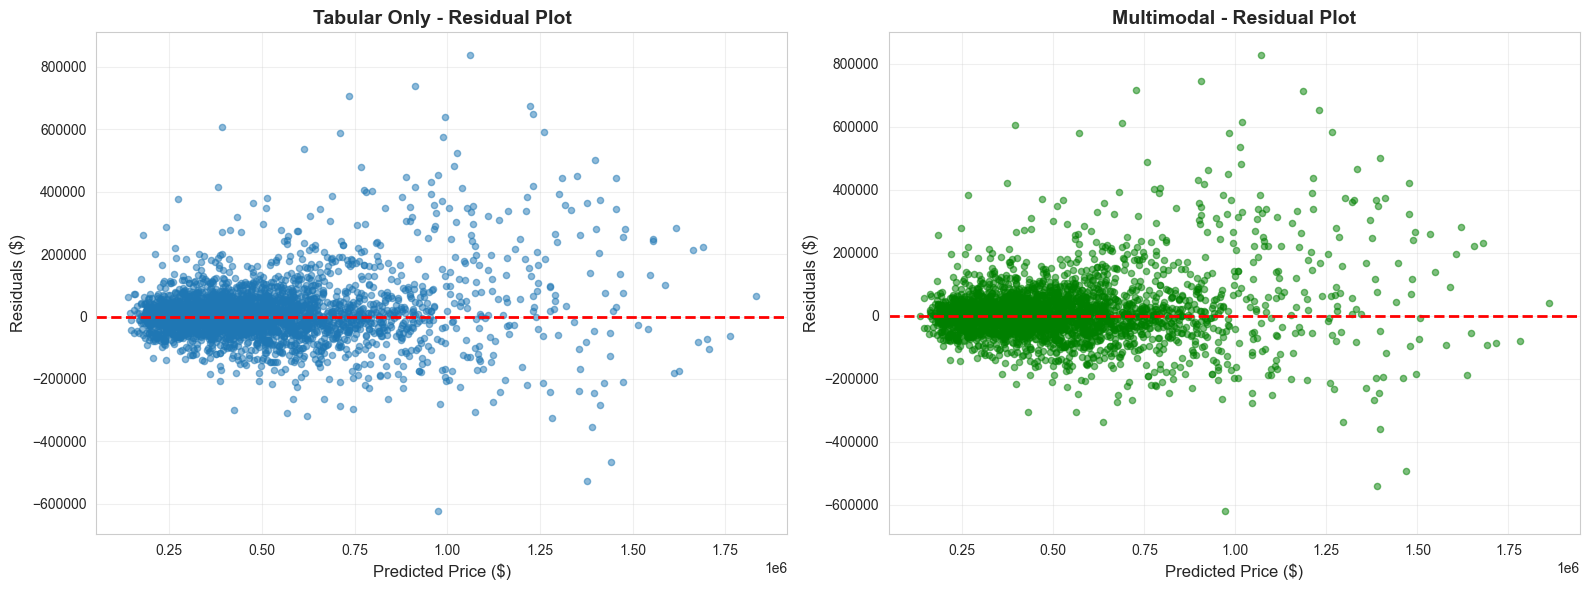

In [13]:
# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

residuals_tabular = actual_usd - preds_tabular_usd
residuals_multimodal = actual_usd - preds_multimodal_usd

# Tabular Only residuals
axes[0].scatter(preds_tabular_usd, residuals_tabular, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[0].set_ylabel('Residuals ($)', fontsize=12)
axes[0].set_title('Tabular Only - Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Multimodal residuals
axes[1].scatter(preds_multimodal_usd, residuals_multimodal, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Multimodal - Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


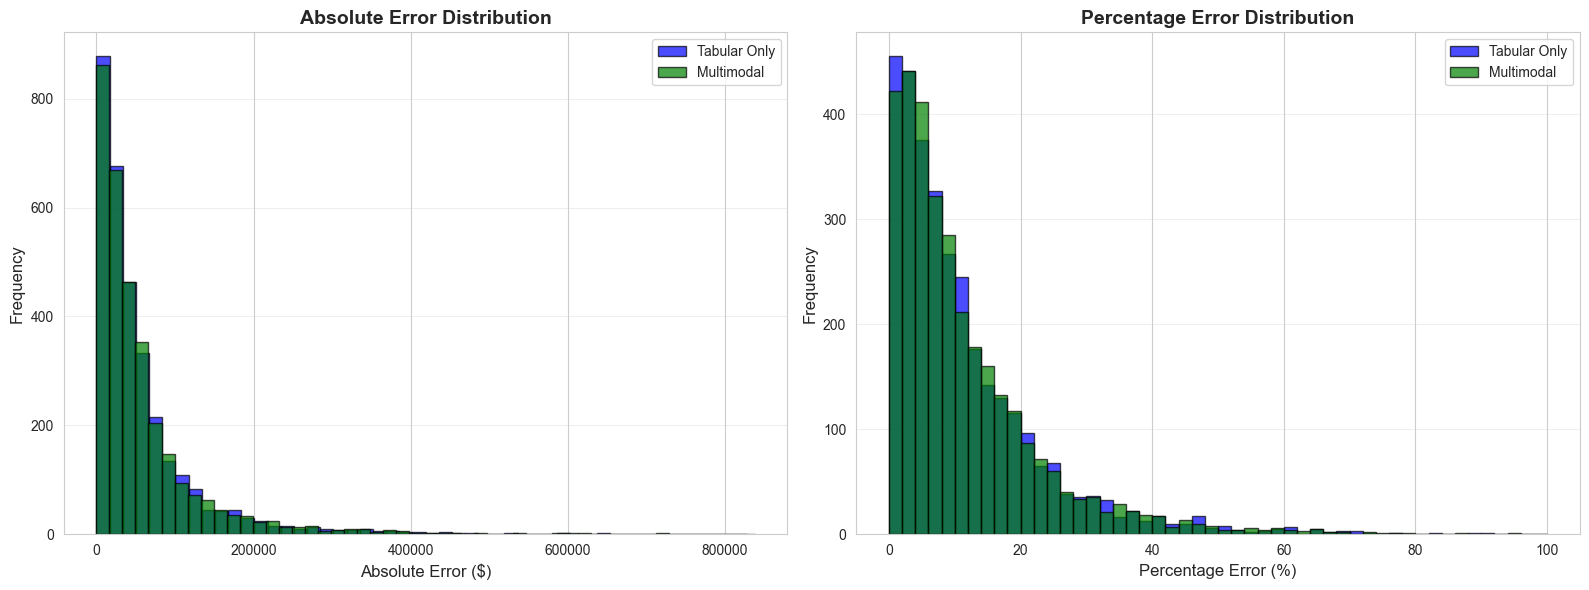

Mean Absolute Percentage Error:
  Tabular Only: 11.80%
  Multimodal: 11.85%


In [14]:
# Error distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute errors
axes[0].hist(np.abs(residuals_tabular), bins=50, alpha=0.7, label='Tabular Only', 
             color='blue', edgecolor='black')
axes[0].hist(np.abs(residuals_multimodal), bins=50, alpha=0.7, label='Multimodal', 
             color='green', edgecolor='black')
axes[0].set_xlabel('Absolute Error ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Absolute Error Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Percentage errors
pct_error_tabular = np.abs(residuals_tabular / actual_usd) * 100
pct_error_multimodal = np.abs(residuals_multimodal / actual_usd) * 100

axes[1].hist(pct_error_tabular, bins=50, alpha=0.7, label='Tabular Only', 
             color='blue', edgecolor='black', range=(0, 100))
axes[1].hist(pct_error_multimodal, bins=50, alpha=0.7, label='Multimodal', 
             color='green', edgecolor='black', range=(0, 100))
axes[1].set_xlabel('Percentage Error (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Percentage Error Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Mean Absolute Percentage Error:")
print(f"  Tabular Only: {pct_error_tabular.mean():.2f}%")
print(f"  Multimodal: {pct_error_multimodal.mean():.2f}%")


In [15]:
# Summary insights
print("="*70)
print("KEY INSIGHTS FROM MODEL COMPARISON")
print("="*70)
print(f"\n1. PERFORMANCE IMPROVEMENT:")
print(f"   - R² Score improved by {r2_improvement:+.2f}%")
print(f"   - MAE reduced by {mae_improvement:+.2f}%")
print(f"   - RMSE reduced by {rmse_improvement:+.2f}%")

print(f"\n2. ABSOLUTE IMPROVEMENTS:")
print(f"   - R² Score: {r2_tabular:.4f} → {r2_multimodal:.4f} (+{r2_multimodal - r2_tabular:.4f})")
print(f"   - MAE: ${mae_tabular:,.2f} → ${mae_multimodal:,.2f} (${mae_tabular - mae_multimodal:,.2f} improvement)")
print(f"   - RMSE: ${rmse_tabular:,.2f} → ${rmse_multimodal:,.2f} (${rmse_tabular - rmse_multimodal:,.2f} improvement)")

print(f"\n3. CONCLUSION:")
if r2_multimodal > r2_tabular:
    print(f"   ✓ The Multimodal approach (Tabular + Satellite Images) significantly")
    print(f"     outperforms the Tabular-only model.")
    print(f"   ✓ Incorporating visual features from satellite imagery provides")
    print(f"     valuable information for property valuation.")
    print(f"   ✓ The visual_score feature captures environmental context that")
    print(f"     traditional tabular features cannot represent.")
else:
    print(f"   The models show similar performance. Further feature engineering")
    print(f"   or model tuning may be needed.")

print("="*70)


KEY INSIGHTS FROM MODEL COMPARISON

1. PERFORMANCE IMPROVEMENT:
   - R² Score improved by -0.07%
   - MAE reduced by -0.30%
   - RMSE reduced by -0.20%

2. ABSOLUTE IMPROVEMENTS:
   - R² Score: 0.8925 → 0.8919 (+-0.0006)
   - MAE: $59,512.36 → $59,692.29 ($-179.92 improvement)
   - RMSE: $98,052.68 → $98,246.95 ($-194.27 improvement)

3. CONCLUSION:
   The models show similar performance. Further feature engineering
   or model tuning may be needed.
